In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from sklearn.linear_model import RANSACRegressor

from glob import glob
from dataclasses import dataclass

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from lib import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

## Load

In [2]:
# data = load("250321-exp7")
data = load('250328-sand1')

## Analysis

### Noise removal and filtering

In [6]:
show = False

noise = data[-1]
clean_psd = []
clean_chi_im = []
averaged_psd = []
averaged_chi_im = []

for i, step in enumerate(data[:-1]):

    # Remove system noise from spectra
    clean_psd.append(step.psd / noise.psd)
    # clean_chi_im.append(step.chi_im / noise.chi_im) # le bruit de chi_im n'est pas vraiment bruit
    clean_chi_im.append(step.chi_im)

    # Moving average filter
    window_size = 10
    averaged_psd.append(moving_average(clean_psd[i], window_size))
    averaged_chi_im.append(moving_average(clean_chi_im[i], window_size))

    if (show): # Plot results
        print(step.filename)
        plt.loglog(step.freqs, clean_psd[i])
        plt.loglog(step.freqs, averaged_psd[i])

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ScalarFormatter())
        plt.xticks([5,10,20,30,40,50,60,70])
        plt.xlabel("$f$ [Hz]")
        plt.ylabel("$S$")
        plt.show()


        plt.loglog(step.freqs, clean_chi_im[i])
        plt.loglog(step.freqs, averaged_chi_im[i])

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ScalarFormatter())
        plt.xticks([5,10,20,30,40,50,60,70])
        plt.xlabel("$f$ [Hz]")
        plt.ylabel("Im $\\chi$")
        plt.show()


/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_31631/387413633.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


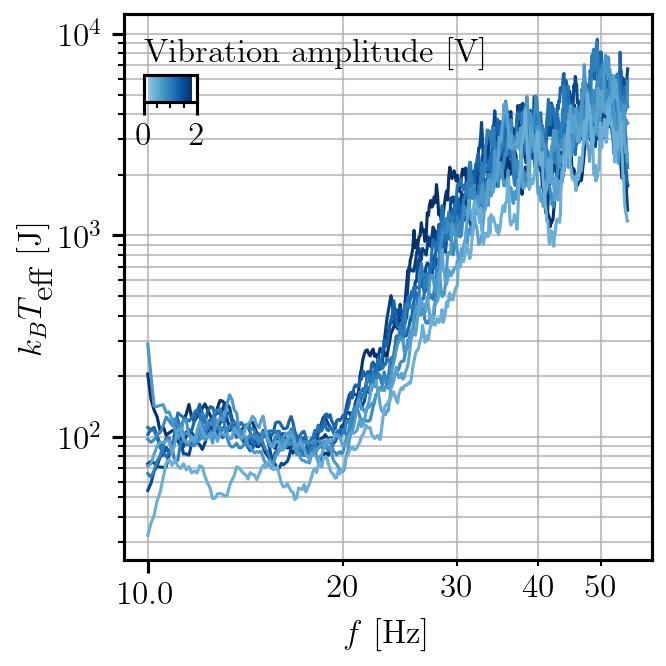

In [4]:
avg_lim = 15
kB_Teff = []
Teff = []
avg_kB_Teff = []
avg_kB_Teff_err = []

max_amplitude = max(step.imposed_vibration for step in data)
min_amplitude = min(step.imposed_vibration for step in data)
cmap = truncate_colormap(plt.cm.Blues, 0.4, 1.0)
norm = mpl.colors.Normalize(vmin=min_amplitude, vmax=max_amplitude)

fig, ax = plt.subplots()

for i, step in enumerate(data[:-1]):
    kB_Teff.append((averaged_psd[i] * 2*np.pi*step.freqs) / (4 *averaged_chi_im[i]))
    Teff.append(kB_Teff[i]/ BOLTZMANN_CONSTANT_JOULE)

    avg_kB_Teff.append(np.mean(kB_Teff[i][step.freqs > avg_lim]))
    avg_kB_Teff_err.append(np.std(kB_Teff[i][step.freqs > avg_lim]))

    color = cmap(step.imposed_vibration / max_amplitude)
    ax.loglog(step.freqs, kB_Teff[i], c=color)
    # plt.xlim(10,55)
    # plt.ylim(1e2, 1e4)
    ax.set_xlabel(r"$f$ [Hz]")
    ax.set_ylabel(r"$k_B T_\textrm{eff}$ [J]")
    # vline = plt.axvline(avg_lim)

plt.grid(True, 'minor')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(ScalarFormatter())

# This could become a function
axins1 = inset_axes(
    ax,
    width="10%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    # loc="upper left",
    bbox_to_anchor=(-0.83,-0.08, 1, 1),
    bbox_transform=ax.transAxes,
)

clb = fig.colorbar(plt.cm.ScalarMappable(norm, cmap), ax=ax, cax=axins1, orientation="horizontal")
clb.ax.set_xticks(ticks = [round(min_amplitude), round(max_amplitude)], minor=False)
clb.ax.set_title("Vibration amplitude [V]", loc='left')

plt.tight_layout()
plt.savefig("../figures/sand_Teff.png")
plt.show()


Fit coefs:  [0.15863065 7.57418296]


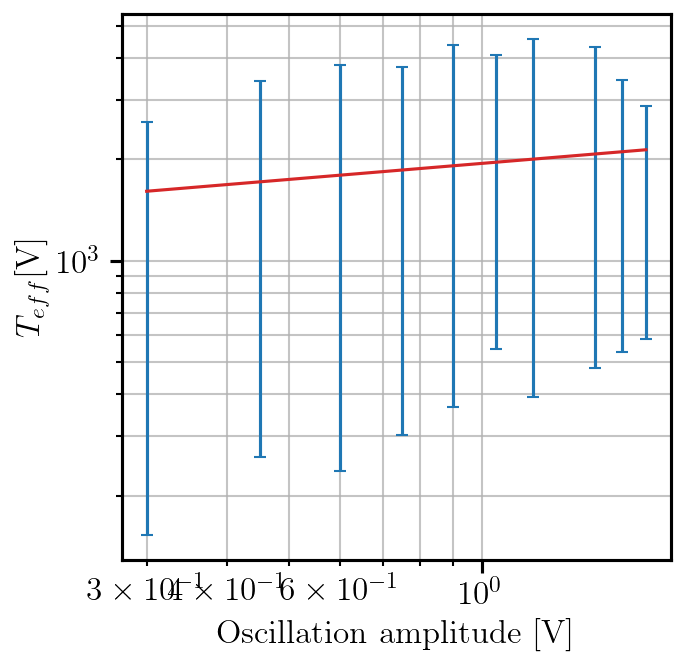

In [5]:
# Teff vs amplitude d'oscillation
amplitudes = np.array([step.imposed_vibration for step in data[:-1]])
plt.errorbar(amplitudes, avg_kB_Teff,
             yerr=avg_kB_Teff_err,
             ls=''
             )

# Fit
xx = np.linspace(min(amplitudes), max(amplitudes), 50)
coefs, cov = np.polyfit(np.log(amplitudes), np.log(avg_kB_Teff), 1, cov=True, w=1/np.array(avg_kB_Teff_err))
yy = np.polyval(coefs, np.log(xx))
plt.plot((xx), np.exp(yy),
         c='C3', ls='-')
print("Fit coefs: ", coefs)

# Fig params
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Oscillation amplitude [V]")
plt.ylabel("$T_{{eff}}$[V]")

plt.grid(True, 'minor')
plt.show()
